#Beginning GAN

In this notebook, I will train my first GAN in order to generate images of celebrity faces. 

##Import Required Libraries

First, import any and all required libraries, including tensorflow, matplotlib, and numpy.

In [139]:
!pip install tensorflow
!pip install matplotlib
!pip install numpy

In [155]:
import tensorflow as tf
import numpy as np
import os
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['resize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
Using TensorFlow backend.


## Process the Data

The data is sample data from Microsoft's MSRA-CFW dataset. It contains a sample of the bigger dataset. We will use the smaller sample at first and then we will retrain the model on the larger dataset at the end.

### Import Data from Github

In [141]:
!git clone https://github.com/sidijju/BeginningGAN
os.chdir('BeginningGAN/thumbnails_features_deduped_sample')
!pwd
!ls

Cloning into 'BeginningGAN'...
remote: Enumerating objects: 2241, done.
remote: Counting objects: 100% (2241/2241), done.
remote: Compressing objects: 100% (2236/2236), done.
remote: Total 2241 (delta 3), reused 2225 (delta 1), pack-reused 0
Receiving objects: 100% (2241/2241), 15.55 MiB | 7.15 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/BeginningGAN/thumbnails_features_deduped_sample/BeginningGAN/thumbnails_features_deduped_sample/BeginningGAN/thumbnails_features_deduped_sample/BeginningGAN/thumbnails_features_deduped_sample
'aaron carter'	'aishwarya rai'  'liv tyler'	   'steve jobs'
'adam brody'	'al gore'	 'martina hingis'
'adrien brody'	'bill gates'	 'michelle obama'


As you can see, there are folders which contain thumbnail clippings for the celebrity each folder is named after. For example, let us look at the contents of the folder  ```bill gates```



In [142]:
os.chdir('bill gates')
!pwd
!ls

/content/BeginningGAN/thumbnails_features_deduped_sample/BeginningGAN/thumbnails_features_deduped_sample/BeginningGAN/thumbnails_features_deduped_sample/BeginningGAN/thumbnails_features_deduped_sample/bill gates
0.jpg	 18.jpg   280.jpg  343.jpg  407.jpg  486.jpg  547.jpg  660.jpg
105.jpg  192.jpg  282.jpg  344.jpg  409.jpg  488.jpg  548.jpg  664.jpg
108.jpg  193.jpg  284.jpg  345.jpg  410.jpg  48.jpg   54.jpg   666.jpg
111.jpg  194.jpg  286.jpg  347.jpg  419.jpg  490.jpg  550.jpg  670.jpg
113.jpg  195.jpg  291.jpg  348.jpg  421.jpg  491.jpg  551.jpg  673.jpg
116.jpg  196.jpg  293.jpg  349.jpg  423.jpg  492.jpg  563.jpg  675.jpg
117.jpg  1.jpg	  294.jpg  34.jpg   425.jpg  493.jpg  565.jpg  680.jpg
119.jpg  200.jpg  295.jpg  350.jpg  426.jpg  494.jpg  56.jpg   682.jpg
122.jpg  201.jpg  297.jpg  351.jpg  429.jpg  496.jpg  570.jpg  684.jpg
124.jpg  203.jpg  298.jpg  352.jpg  42.jpg   497.jpg  585.jpg  685.jpg
127.jpg  204.jpg  2.jpg    354.jpg  431.jpg  498.jpg  587.jpg  686.jpg
12.jpg	 20

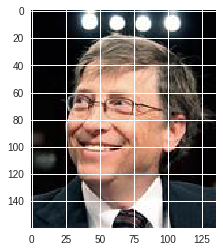

In [143]:
img=mpimg.imread('187.jpg')
imgplot = plt.imshow(img)
plt.show()
os.chdir("..")

###Sort Images by Label

Here we will compile the entire dataset into a dataframe.

In [144]:
data = {}
data['labels'] = []
data['images'] = []
for dir in os.walk(os.getcwd()):
  os.chdir(dir[0])
  for file in dir[2]:
    if(file[-4:]==".jpg"):
      img = np.array(mpimg.imread(str(file)))
      img = resize(img, (160, 160))
      data['labels'].append(dir[0].rsplit('/',1)[1])
      data['images'].append(img)
  os.chdir("..")

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Let's also figure out how much data is in the dataset for each label and in total.

In [145]:
total = 0
print("--Dataset Distribution--")
for label in set(data['labels']):
  print("%-19s %s" % (label + ":", str(data['labels'].count(label))))
  total += data['labels'].count(label)
print("------------------------\n%-19s %s" % ("Total: ", str(total)))

--Dataset Distribution--
adam brody:         83
bill gates:         288
adrien brody:       76
steve jobs:         156
liv tyler:          393
michelle obama:     123
martina hingis:     51
aaron carter:       48
aishwarya rai:      781
al gore:            175
------------------------
Total:              2174


###Split into Training, Testing, and Validation

Fill  ```labels``` and ```images``` as numpy arrays with data.



In [148]:
#set images and labels to numpy arrays

labels = np.array(data['labels'])
images = np.asarray(data['images'])
print(labels.shape)
print(images.shape)


(2174,)
(2174, 160, 160, 3)


Split data into testing and training data

In [0]:
num_images, nrows, ncols, channels = images.shape

np.rollaxis(images, 3, 1)  

# split into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = .2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .125)

### Normalize the Data

In order to reduce variation in the data, we will normalize the RGB images so that they range between 0 and 1. We will also reshape the labels.

In [0]:
X_train = X_train.astype('float')/255
X_test = X_test.astype('float')/255
X_val = X_val.astype('float')/255

y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)
y_val = y_val.reshape(len(y_val), 1)



##Create the GAN

###Define the Discriminator Network

In [172]:
def DiscriminatorNet(input_size = (160, 160, 3)):
  
    inputs   = Input(input_size)
    
    flatten1 = Flatten()(inputs)
    
    lReLU1   = LeakyReLU(0.2)(flatten1)
    drop1    = Dropout(0.3)(lReLU1)
    
    dense1   = Dense(1024, activation = 'linear')(drop1)
    lReLU2   = LeakyReLU(0.2)(dense1)
    drop2    = Dropout(0.3)(lReLU2)
    
    dense2   = Dense(512, activation = 'linear')(drop2)
    lReLU3   = LeakyReLU(0.2)(dense2)
    drop3    = Dropout(0.3)(lReLU3)
    
    dense3   = Dense(256, activation = 'linear')(drop3)
    lReLU4   = LeakyReLU(0.2)(dense3)
    drop4    = Dropout(0.3)(lReLU4)
    
    dense4   = Dense(128, activation = 'linear')(drop4)
    lReLU5   = LeakyReLU(0.2)(dense4)
    drop5    = Dropout(0.3)(lReLU5)
    
    model = Model(input = inputs, output = drop5)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()
    
    return model
  
discriminator = DiscriminatorNet()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 160, 160, 3)       0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 76800)             0         
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 76800)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 76800)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              78644224  
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("dr...)`


### Define the Generator Network

In [0]:
def GeneratorNet():